# Convoluted Neural Network

In [1]:
import os, sys
import sklearn.preprocessing as pre
import numpy as np

In [2]:
''' Add the datasets and libraries to the system path '''

# Find the path to our implementations
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
home_directory = os.path.dirname(parent_directory)
libraries_path = os.path.join(home_directory, 'Libraries')

# Find the path to the datasets
datasets_path = os.path.join(home_directory, 'Datasets')

# Add them both to the system path
sys.path.append(datasets_path)
sys.path.append(libraries_path)

if os.path.exists('trained_models') == False:
    os.mkdir('trained_models')

In [3]:
''' Load the dataset '''

dataset = np.load(os.path.join(datasets_path, 'fashion_train.npy'))
print("Dataset shape: ", dataset.shape)
dataset_test = np.load(os.path.join(datasets_path, 'fashion_test.npy'))
print("Dataset shape: ", dataset_test.shape)

Dataset shape:  (10000, 785)
Dataset shape:  (5000, 785)


In [4]:
X = dataset[:, :-1]  # Define the images as all columns except the last one
y = dataset[:, -1] # Define the labels as the last column
X_test = dataset_test[:, :-1]
y_test = dataset_test[:, -1]

In [5]:
print(type(X))
print("X shape: ", X.shape)
print(type(y))
print("y shape: ", y.shape)
print(type(X_test))
print("X_test shape: ", X_test.shape)
print(type(y_test))
print("y_test shape: ", y_test.shape)

<class 'numpy.ndarray'>
X shape:  (10000, 784)
<class 'numpy.ndarray'>
y shape:  (10000,)
<class 'numpy.ndarray'>
X_test shape:  (5000, 784)
<class 'numpy.ndarray'>
y_test shape:  (5000,)


In [6]:
# scaling the images
scaler = pre.StandardScaler()
X = scaler.fit_transform(X)
X_test = scaler.fit_transform(X_test)

In [7]:
from CNN import CNN

In [8]:
cnn_model = CNN()

if os.path.exists('trained_models/cnn_model'):
    cnn_model.load_model('cnn_model')
else:
    # cnn_model.fit(X, y)
    cnn_model.fit(X, y, X_test, y_test) # include test set for validation for plotting
    cnn_model.save_model('cnn_model')

In [9]:
cnn_model.evaluate(X_test, y_test)

0.8848

In [10]:
cnn_model.summary()

Model summary:
Epochs: 28
Learning rate: 0.0025474653904364957
Layers:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
              ReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
           Dropout-7             [-1, 64, 7, 7]               0
           Flatten-8                 [-1, 3136]               0
            Linear-9                  [-1, 128]         401,536
             ReLU-10                  [-1, 128]               0
          Dropout-11                  [-1, 128]               0
           Linear-12                    [-1, 5]             645
Total params: 420,997
Trainable 

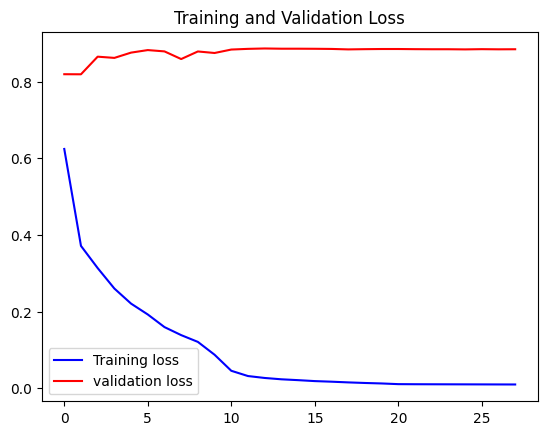

In [17]:
# Plot the loss and accuracy curves for training and validation
import matplotlib.pyplot as plt
plt.plot(cnn_model.history['loss'], color='b', label="Training loss")
plt.plot(cnn_model.history['val_loss'], color='r', label="validation loss")
plt.title("Training and Validation Loss")
plt.legend(loc='best')
plt.savefig(os.path.join(home_directory,'Exported_Data/CNN_loss.png'), dpi=500)
plt.show()